# Exploring Assetprice Periodicity

Code to

- import libraries
- extract data from api
- engineer features and insert data into dataframe
- plot charts

In [1]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import pylab
import scipy.stats as stats
from scipy.fft import fft, fftfreq, ifft
from scipy.signal import find_peaks


def query_api() -> dict:
    '''Sends a get request to the timeseries API for each valid time interval. Output:
    {
        '5m' : [list of 365 dicts]
        '1h' : [list of 365 dicts]
        '6h' : [list of 365 dicts]
        '24h': [list of 365 dicts]
    }
    '''
    result = dict()
    item_id = 13190
    valid_timesteps = ['5m', '1h', '6h', '24h']
    intentions = {
        'User-Agent': 'Need to find optimal price to buy CHEAP bonds.',
        'From': 'A poor osrs player with 400 total level.'
    }
    for timestep in valid_timesteps:
        url = f'https://prices.runescape.wiki/api/v1/osrs/timeseries?timestep={timestep}&id={item_id}'
        result[timestep] = requests.get(url, headers=intentions).json()['data']
    return result

def json_to_df(json_data:list) -> pd.DataFrame:
    '''Dataframe insertion and feature engineering.'''
    result = pd.DataFrame()
    for data_point in json_data:
        row = {
            'unix_time': data_point.get('timestamp')
            , 'bid_price': data_point.get('avgLowPrice')
            , 'volume': data_point.get('lowPriceVolume', 0)
        }
        temp_df = pd.DataFrame.from_dict([row], orient='columns')
        result = pd.concat([result, temp_df], ignore_index=True)
    result['time_stamp'] = pd.to_datetime(result['unix_time'], unit='s')
    result['log_delta'] = np.log(result['bid_price'].astype(float)).diff()
    result['log_delta'].fillna(0, inplace=True)
    result['delta'] = result['bid_price'].astype(float).diff()
    result['delta'].fillna(0, inplace=True)
    delta_signal = result['delta'].values
    n = len(delta_signal)
    timestep = (result['time_stamp'][1] - result['time_stamp'][0]).total_seconds()
    result['freq'] = fftfreq(n, d=timestep)
    amplitude = np.abs(fft(delta_signal)) / (n/2)
    result['amplitude'] = amplitude
    amp_mean = amplitude.mean()
    amp_std = amplitude.std()
    result['amp_clean'] = np.where(amplitude > (3*amp_std+amp_mean), amplitude, 0)
    clean_fft = fft(delta_signal)
    clean_fft[result['amp_clean'] == 0] = 0
    result['delta_clean'] = ifft(clean_fft).real
    peaks, _ = find_peaks(-result['delta_clean'])
    result['buy_signal'] = False
    result.loc[peaks, 'buy_signal'] = True
    ## Could implement sell signals too (-1sell, 0idle, 1buy)
    return result

def plot_timeseries(df:pd.DataFrame, column_name:str) -> None:
    '''Valid columns: bid_price, log_delta, delta, delta_clean.'''
    valid_columns = {'bid_price', 'log_delta', 'delta', 'delta_clean'}
    if column_name not in valid_columns:
        raise ValueError('Tried to plot invalid column!')
    match column_name:
        case 'bid_price':
            colour = 'xkcd:red'
        case 'log_delta':
            colour = 'darkblue'
        case 'delta':
            colour = 'darkblue'
        case _:
            colour = 'magenta'
    plt.figure(figsize=(12,6))
    plt.plot(df['time_stamp'], df[[column_name]], colour)
    plt.xticks(rotation=45, ha='right')
    plt.xlabel('Timestamp')
    plt.ylabel(column_name)
    plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m-%d %H:%M:%S'))
    if 'log' not in column_name:
        plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x,_ : f'{int(x):,}'))
    plt.title(f'Timeseries of {column_name}')

def plot_fft(df:pd.DataFrame, log:bool=False) -> None:
    column_name = 'amplitude'
    plt.figure(figsize=(12,6))
    plt.plot(df[df['freq']>=0]['freq'], df[df['freq']>=0][column_name].values, 'goldenrod')
    plt.xlabel('Frequency (Hz)')
    # 0.00001160 hz ~= daily cycle 
    # 0.00000165 hz ~= weekly cycle
    plt.ylabel(column_name)
    if not log:
        plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x,_ : f'{int(x):,}'))
    plt.title(f'Frequencies present in {column_name}')

def plot_comparison(df:pd.DataFrame, log:bool=False) -> None:
    noisy_column = 'delta'
    clean_column = 'delta_clean'
    noisy_colour = 'pink'
    clean_colour = 'dodgerblue'
    plt.figure(figsize=(12,6))
    plt.plot(df['time_stamp'], df[noisy_column], noisy_colour)
    plt.plot(df['time_stamp'], df[clean_column], clean_colour)
    plt.xticks(rotation=45, ha='right')
    plt.xlabel('Timestamp')
    plt.ylabel('Value')
    plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m-%d %H:%M:%S'))
    if not log:
        plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x,_ : f'{int(x):,}'))
    plt.title(f'Timeseries of {noisy_column} and {clean_column}')

def plot_quantiles(df:pd.DataFrame, log:bool=True) -> None:
    column_name = 'log_delta' if log else 'delta'
    stats.probplot(df[column_name], fit=False, plot=pylab)
    plt.xlabel('Theoretical Guassian Quantiles')
    plt.ylabel('Empirical Quantiles')
    plt.title('QQ plot')

def plot_kde(df:pd.DataFrame, log:bool=True) -> None:
    column_name = 'log_delta' if log else 'delta'
    delta_data = df[column_name].dropna().values
    x = np.linspace(min(delta_data), max(delta_data), 250)
    data_kde = stats.gaussian_kde(delta_data)
    plt.plot(x, data_kde(x), 'darkblue')
    plt.axvline(x=0, color='red', linestyle='--')
    plt.xlabel('Values')
    plt.ylabel('Density')
    plt.title('KDE plot')

Get data

In [2]:
raw_data = query_api()
df_5m = json_to_df(raw_data['5m'])
df_1h = json_to_df(raw_data['1h'])
df_6h = json_to_df(raw_data['6h'])
df_1d = json_to_df(raw_data['24h'])

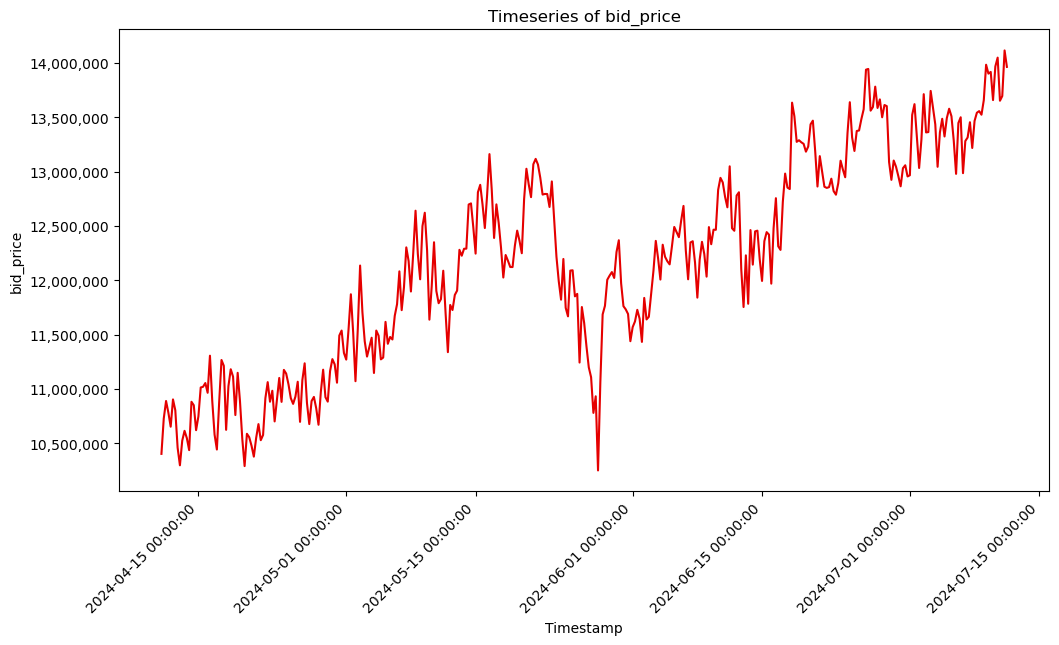

In [3]:
plot_timeseries(df_6h, 'bid_price')

Let us look at delta to eliminate linear trend

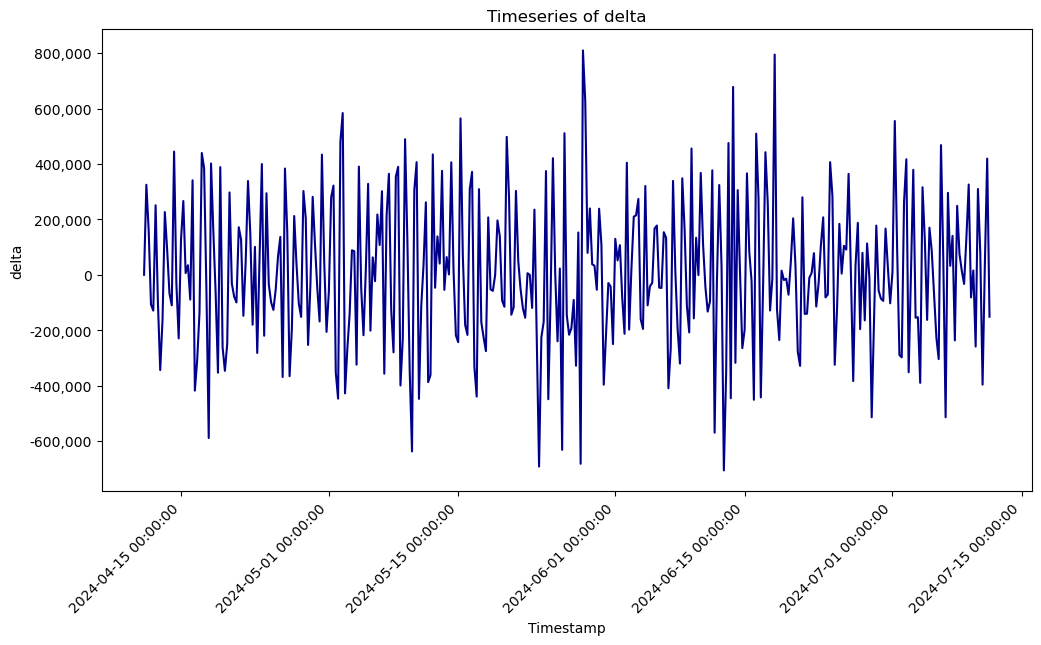

In [4]:
plot_timeseries(df_6h, 'delta')

Let us find out if periodicity is present

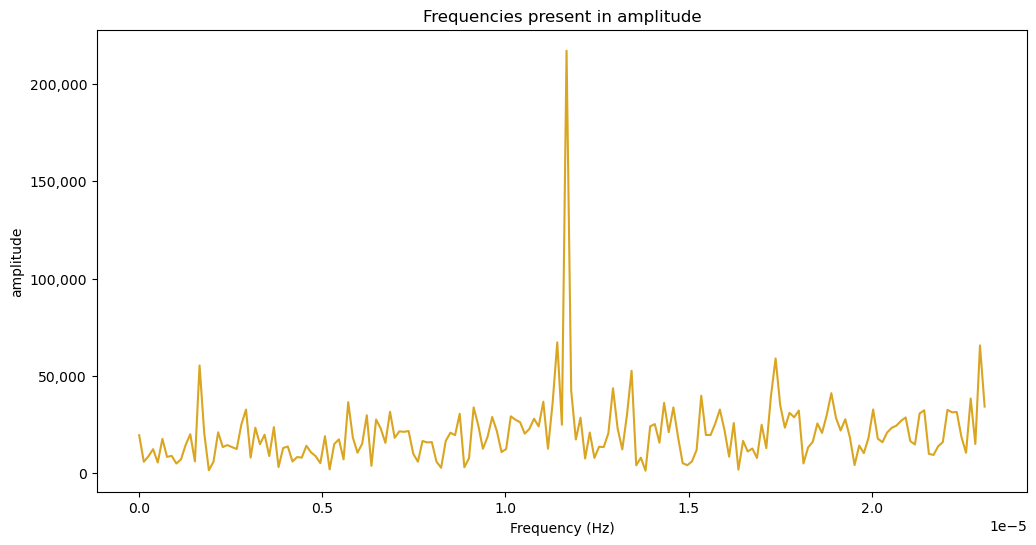

In [5]:
plot_fft(df_6h)

Wow!! 0.000012 hz corresponds to a pattern that repeats each day!

In [6]:
#plot_quantiles(df_6h)

In [7]:
#plot_kde(df_6h, True)

What if we try to filter for this periodicity? (flatline if no periodicity)

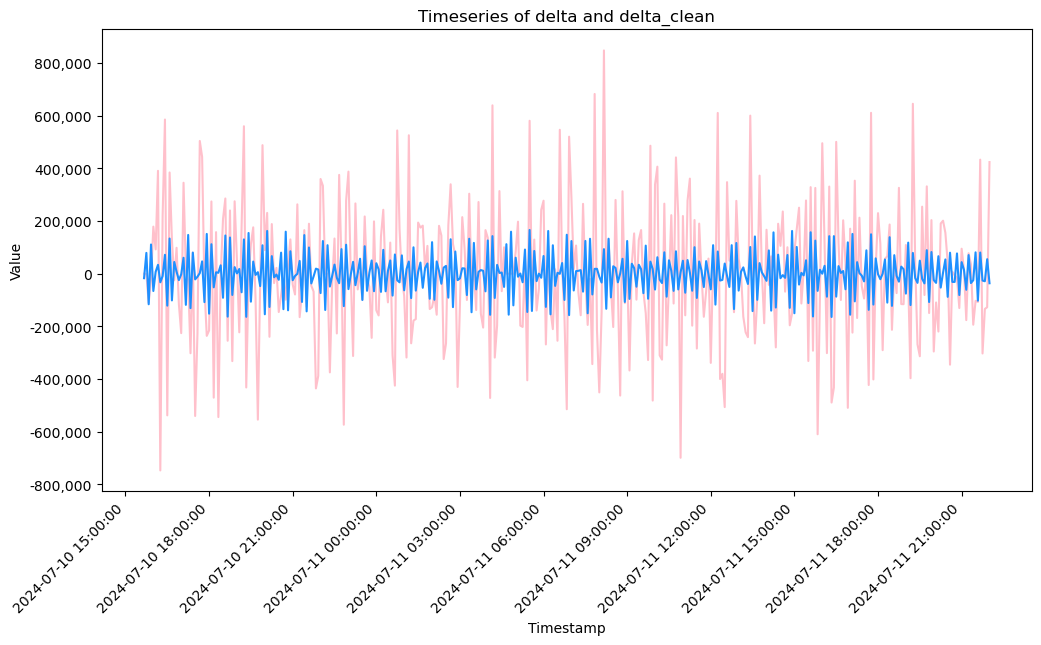

In [8]:
plot_comparison(df_5m)

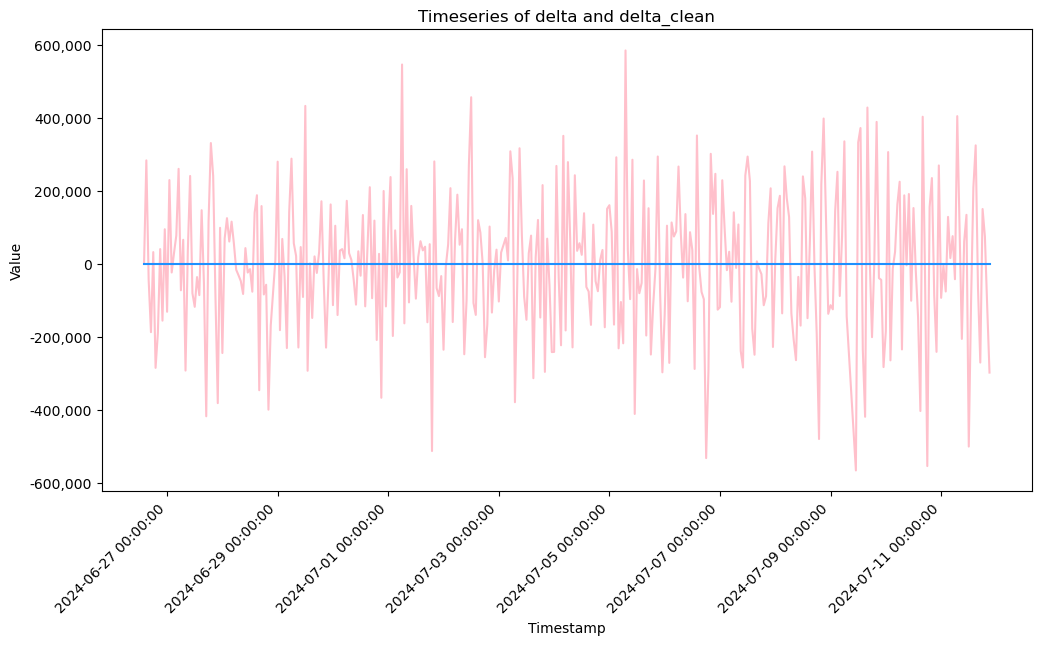

In [9]:
plot_comparison(df_1h)

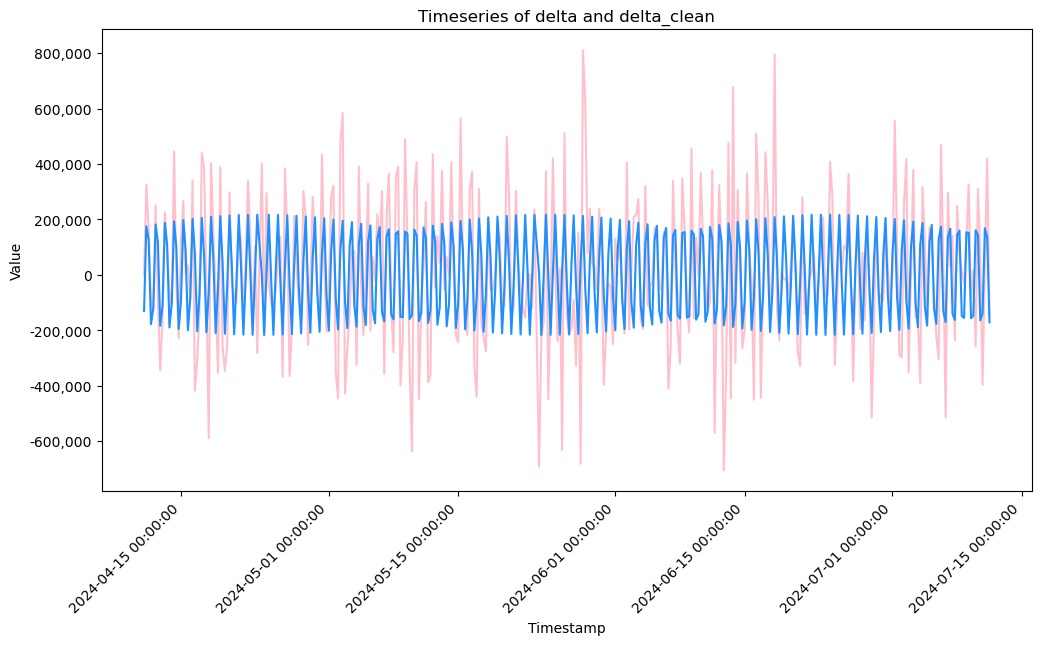

In [10]:
plot_comparison(df_6h)
## {.3 + |.2 sin(x)|} sin(100x)

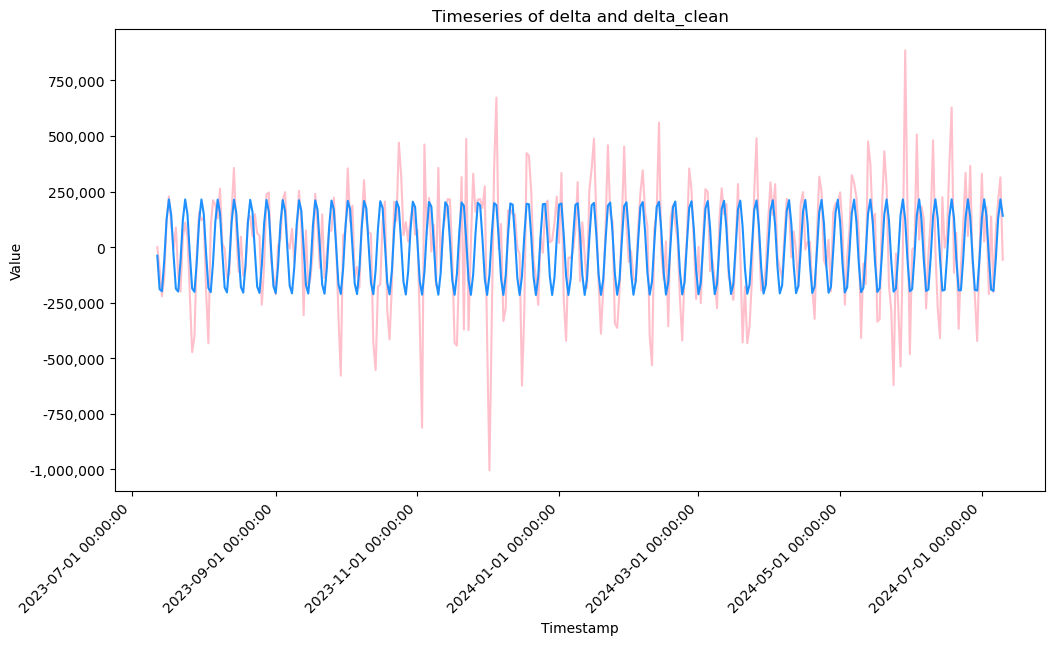

In [11]:
plot_comparison(df_1d)

In [12]:
df_5m[['time_stamp', 'volume', 'bid_price', 'buy_signal']].tail(25)

,time_stamp,volume,bid_price,buy_signal
340,2024-07-11 20:00:00,17,14007379,False
341,2024-07-11 20:05:00,6,13897938,True
342,2024-07-11 20:10:00,13,13678235,False
343,2024-07-11 20:15:00,11,13868445,True
344,2024-07-11 20:20:00,22,14069327,False
345,2024-07-11 20:25:00,34,14224175,False
346,2024-07-11 20:30:00,18,14266208,True
347,2024-07-11 20:35:00,33,13920779,False
348,2024-07-11 20:40:00,12,13927874,False
349,2024-07-11 20:45:00,30,13922299,True


A crude, first effort at a dirty trading strategy